# Demo nhận diện người trong ảnh

In [1]:
# Import modules 
import os
import cv2
import time
import json
import glob
import torch
import numpy as np
import pandas as pd
from tqdm import tqdm
import skimage.io as io
from pathlib import Path

import matplotlib.pyplot as plt
from pycocotools.coco import COCO
from typing import Callable, List, Optional, Tuple
from torch.utils.data import Dataset, DataLoader
from sklearn.model_selection import train_test_split
import torchvision
import torch.nn as nn
from PIL import Image
import torch.nn.functional as F

## 1. Mở và phân tích dữ liệu

In [2]:
# base path of the dataset
DATASET_PATH = '/home/vankhoa/datasets/PennFudanPed'
OUTPUT_PATH = ''

# define the path to the images and masks dataset
IMAGE_DATASET_PATH = os.path.join(DATASET_PATH, "PNGImages")
MASK_DATASET_PATH = os.path.join(DATASET_PATH, "PedMasks")
# define the test split
TEST_SPLIT = 0.15
# determine the device to be used for training and evaluation
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"
# determine if we will be pinning memory during data loading
PIN_MEMORY = True if DEVICE == "cuda" else False

In [3]:
# load the image and mask filepaths in a sorted manner
imagePaths = sorted(glob.glob(IMAGE_DATASET_PATH + '/*'))
maskPaths = sorted(glob.glob(MASK_DATASET_PATH + '/*'))
# partition the data into training and testing splits using 85% of
# the data for training and the remaining 15% for testing
split = train_test_split(imagePaths, maskPaths,
	test_size=TEST_SPLIT, random_state=42)
# unpack the data split
(trainImages, testImages) = split[:2]
(trainMasks, testMasks) = split[2:]
# write the testing image paths to disk so that we can use then
# when evaluating/testing our model
print("[INFO] saving testing image paths...")
f = open('test.txt', "w")
f.write("\n".join(testImages))
f.close()

[INFO] saving testing image paths...


## 2. Khởi tạo Dataset cho pytorch

In [4]:
class SegmentationDataset(Dataset):
    def __init__(self, imagePaths, maskPaths, transforms):
        # store the image and mask filepaths, and augmentation
        # transforms
        self.imagePaths = imagePaths
        self.maskPaths = maskPaths
        self.transforms = transforms
    def __len__(self):
        # return the number of total samples contained in the dataset
        return len(self.imagePaths)
    def __getitem__(self, idx):
        # grab the image path from the current index
        imagePath = self.imagePaths[idx]
        # load the image from disk, swap its channels from BGR to RGB,
        # and read the associated mask from disk in grayscale mode
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        mask = cv2.imread(self.maskPaths[idx], cv2.IMREAD_GRAYSCALE)

        mask = cv2.threshold(mask, 0.5, 255, cv2.THRESH_BINARY)[1]
        # check to see if we are applying any transformations
        if self.transforms is not None:
            # apply the transformations to both image and its mask
            image = self.transforms(image)
            mask = self.transforms(mask)
        # return a tuple of the image and its mask
        return (image, mask)

In [5]:
from torchvision import transforms

transform = transforms.Compose([
    transforms.ToPILImage(),
    transforms.Resize((300,300)),
    transforms.ToTensor()
])

dataset_train = SegmentationDataset(imagePaths=trainImages, maskPaths=trainMasks,
	transforms=transform)
dataset_test = SegmentationDataset(imagePaths=testImages, maskPaths=testMasks,
    transforms=transform)

Plot một sample trong tập dữ liệu

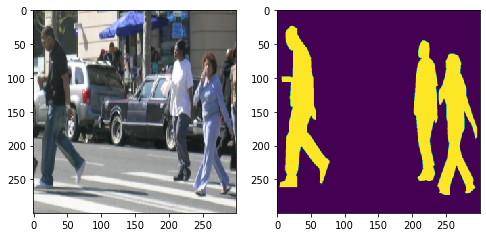

In [6]:
data = dataset_train[2]
figure = plt.figure(figsize=(8, 8))
figure.add_subplot(1, 2, 1)
plt.imshow(data[0].permute(1,2,0).squeeze())
figure.add_subplot(1, 2, 2)
plt.imshow(data[1].squeeze())
plt.show()

Khởi tạo dataloader

In [7]:
batch_size = 8
num_epochs = 30
device = 'cuda:0'

train_dataloader = DataLoader(dataset_train, batch_size=2, shuffle=True, num_workers=8)
test_dataloader = DataLoader(dataset_test, batch_size=2, shuffle=False, num_workers=8)

train_features, train_labels = next(iter(train_dataloader))
print(f"Feature batch shape: {train_features.shape}")
print(f"Labels batch shape: {train_labels.shape}")

Feature batch shape: torch.Size([2, 3, 300, 300])
Labels batch shape: torch.Size([2, 1, 300, 300])


## 3. Khởi tạo mô hình

In [8]:
# Model
from torchvision import models
from torch.nn import BCEWithLogitsLoss
from torch.optim import Adam

model = models.segmentation.fcn_resnet101(num_classes=2).to(device)

# initialize loss function and optimizer
lossFunc = nn.CrossEntropyLoss()
opt = Adam(model.parameters(), lr=1e-5)
# calculate steps per epoch for training and test set
trainSteps = len(dataset_train) // batch_size
testSteps = len(dataset_test) // batch_size
# initialize a dictionary to store training history
H = {"train_loss": [], "test_loss": []}

In [9]:
# Try one iteration
#logits = model(train_features.to(device))
#print(logits)

## 4.Huấn luyện mô hình

In [10]:
# loop over epochs
print("[INFO] training the network...")
startTime = time.time()
best_loss = 1000
for e in tqdm(range(num_epochs)):
    # set the model in training mode
    model.train()
    # initialize the total training and validation loss
    totalTrainLoss = 0
    totalTestLoss = 0
    # loop over the training set
    for (i, (x, y)) in enumerate(train_dataloader):
        # send the input to the device
        (x, y) = (x.to(device), y.to(device))
        # perform a forward pass and calculate the training loss
        pred = model(x)['out']
        loss = lossFunc(pred, y.long().squeeze())
        # first, zero out any previously accumulated gradients, then
        # perform backpropagation, and then update model parameters
        opt.zero_grad()
        loss.backward()
        opt.step()
        # add the loss to the total training loss so far
        totalTrainLoss += loss
    # switch off autograd
    with torch.no_grad():
        # set the model in evaluation mode
        model.eval()
        # loop over the validation set
        for (x, y) in test_dataloader:
            # send the input to the device
            (x, y) = (x.to(device), y.to(device))
            # make the predictions and calculate the validation loss
            pred = model(x)['out']
            totalTestLoss += lossFunc(pred, y.long().squeeze())
    # calculate the average training and validation loss
    avgTrainLoss = totalTrainLoss / trainSteps
    avgTestLoss = totalTestLoss / testSteps

    if avgTestLoss < best_loss:
        torch.save(model, 'best_model.pth')
        best_loss = avgTestLoss

    # update our training history
    H["train_loss"].append(avgTrainLoss.cpu().detach().numpy())
    H["test_loss"].append(avgTestLoss.cpu().detach().numpy())
    # print the model training and validation information
    print("[INFO] EPOCH: {}/{}".format(e + 1, num_epochs))
    print("Train loss: {:.6f}, Test loss: {:.4f}".format(
        avgTrainLoss, avgTestLoss))
# display the total time needed to perform the training
endTime = time.time()
print("[INFO] total time taken to train the model: {:.2f}s".format(
	endTime - startTime))

  0%|          | 0/30 [00:00<?, ?it/s]

[INFO] training the network...


  3%|▎         | 1/30 [00:17<08:38, 17.89s/it]

[INFO] EPOCH: 1/30
Train loss: 1.886636, Test loss: 2.2968


  7%|▋         | 2/30 [00:35<08:16, 17.75s/it]

[INFO] EPOCH: 2/30
Train loss: 1.044439, Test loss: 0.9771


 10%|█         | 3/30 [00:53<08:07, 18.04s/it]

[INFO] EPOCH: 3/30
Train loss: 0.709867, Test loss: 0.7238


 13%|█▎        | 4/30 [01:12<07:50, 18.10s/it]

[INFO] EPOCH: 4/30
Train loss: 0.568852, Test loss: 0.6524


 17%|█▋        | 5/30 [01:30<07:33, 18.12s/it]

[INFO] EPOCH: 5/30
Train loss: 0.492521, Test loss: 0.6121


 20%|██        | 6/30 [01:48<07:13, 18.07s/it]

[INFO] EPOCH: 6/30
Train loss: 0.447345, Test loss: 0.6005


 23%|██▎       | 7/30 [02:06<06:57, 18.16s/it]

[INFO] EPOCH: 7/30
Train loss: 0.404237, Test loss: 0.5552


 27%|██▋       | 8/30 [02:24<06:39, 18.15s/it]

[INFO] EPOCH: 8/30
Train loss: 0.379101, Test loss: 0.5483


 30%|███       | 9/30 [02:43<06:23, 18.28s/it]

[INFO] EPOCH: 9/30
Train loss: 0.356443, Test loss: 0.5374


 33%|███▎      | 10/30 [03:00<05:59, 17.98s/it]

[INFO] EPOCH: 10/30
Train loss: 0.339517, Test loss: 0.5406


 37%|███▋      | 11/30 [03:19<05:45, 18.18s/it]

[INFO] EPOCH: 11/30
Train loss: 0.312785, Test loss: 0.5256


 40%|████      | 12/30 [03:37<05:28, 18.22s/it]

[INFO] EPOCH: 12/30
Train loss: 0.303553, Test loss: 0.5158


 43%|████▎     | 13/30 [03:56<05:13, 18.43s/it]

[INFO] EPOCH: 13/30
Train loss: 0.290925, Test loss: 0.5092


 47%|████▋     | 14/30 [04:14<04:53, 18.37s/it]

[INFO] EPOCH: 14/30
Train loss: 0.274721, Test loss: 0.5064


 50%|█████     | 15/30 [04:33<04:37, 18.47s/it]

[INFO] EPOCH: 15/30
Train loss: 0.263972, Test loss: 0.5012


 53%|█████▎    | 16/30 [04:50<04:14, 18.16s/it]

[INFO] EPOCH: 16/30
Train loss: 0.250287, Test loss: 0.5033


 57%|█████▋    | 17/30 [05:09<03:57, 18.29s/it]

[INFO] EPOCH: 17/30
Train loss: 0.241625, Test loss: 0.4802


 60%|██████    | 18/30 [05:26<03:35, 17.95s/it]

[INFO] EPOCH: 18/30
Train loss: 0.233881, Test loss: 0.4857


 63%|██████▎   | 19/30 [05:43<03:14, 17.70s/it]

[INFO] EPOCH: 19/30
Train loss: 0.225887, Test loss: 0.4846


 67%|██████▋   | 20/30 [06:01<02:55, 17.59s/it]

[INFO] EPOCH: 20/30
Train loss: 0.216957, Test loss: 0.4834


 70%|███████   | 21/30 [06:18<02:37, 17.54s/it]

[INFO] EPOCH: 21/30
Train loss: 0.210022, Test loss: 0.4905


 73%|███████▎  | 22/30 [06:35<02:19, 17.44s/it]

[INFO] EPOCH: 22/30
Train loss: 0.204040, Test loss: 0.4812


 77%|███████▋  | 23/30 [06:52<02:01, 17.36s/it]

[INFO] EPOCH: 23/30
Train loss: 0.196926, Test loss: 0.4980


 80%|████████  | 24/30 [07:09<01:43, 17.27s/it]

[INFO] EPOCH: 24/30
Train loss: 0.191468, Test loss: 0.4960


 83%|████████▎ | 25/30 [07:26<01:26, 17.20s/it]

[INFO] EPOCH: 25/30
Train loss: 0.184199, Test loss: 0.4819


 87%|████████▋ | 26/30 [07:45<01:10, 17.55s/it]

[INFO] EPOCH: 26/30
Train loss: 0.180368, Test loss: 0.4775


 90%|█████████ | 27/30 [08:02<00:52, 17.45s/it]

[INFO] EPOCH: 27/30
Train loss: 0.177951, Test loss: 0.4819


 93%|█████████▎| 28/30 [08:19<00:34, 17.45s/it]

[INFO] EPOCH: 28/30
Train loss: 0.175850, Test loss: 0.4832


 97%|█████████▋| 29/30 [08:37<00:17, 17.51s/it]

[INFO] EPOCH: 29/30
Train loss: 0.169584, Test loss: 0.4946


100%|██████████| 30/30 [08:55<00:00, 17.83s/it]

[INFO] EPOCH: 30/30
Train loss: 0.166777, Test loss: 0.4956
[INFO] total time taken to train the model: 535.04s


Vẽ đồ thị loss của tập train và validation

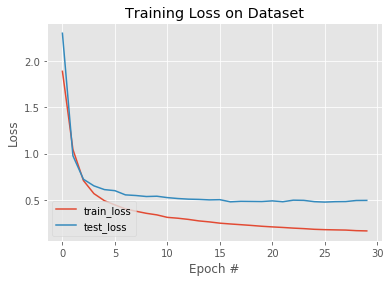

In [11]:
# plot the training loss
plt.style.use("ggplot")
plt.figure()
plt.plot(H["train_loss"], label="train_loss")
plt.plot(H["test_loss"], label="test_loss")
plt.title("Training Loss on Dataset")
plt.xlabel("Epoch #")
plt.ylabel("Loss")
plt.legend(loc="lower left")
plt.savefig('loss.png')
# serialize the model to disk
torch.save(model, 'model.pth')

## 3. Sử dụng mô hình để dự đoán

In [12]:
def prepare_plot(origImage, origMask, predMask):
	# initialize our figure
	figure, ax = plt.subplots(nrows=1, ncols=3, figsize=(10, 10))
	# plot the original image, its mask, and the predicted mask
	ax[0].imshow(origImage)
	ax[1].imshow(origMask)
	ax[2].imshow(predMask)
	# set the titles of the subplots
	ax[0].set_title("Image")
	ax[1].set_title("Original Mask")
	ax[2].set_title("Predicted Mask")
	# set the layout of the figure and display it
	figure.tight_layout()
	figure.show()

In [15]:
def make_predictions(model, imagePath):
    # set model to evaluation mode
    model.eval()
    # turn off gradient tracking
    with torch.no_grad():
        # load the image from disk, swap its color channels, cast it
        # to float data type, and scale its pixel values
        image = cv2.imread(imagePath)
        image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)
        image = image.astype("float32") / 255.0
        # resize the image and make a copy of it for visualization
        image = cv2.resize(image, (300, 300))
        orig = image.copy()
        # find the filename and generate the path to ground truth
        # mask
        filename = imagePath.split(os.path.sep)[-1]
        print(imagePath)
        groundTruthPath = os.path.join(MASK_DATASET_PATH, filename.replace('.png', '_mask.png'))
        print(groundTruthPath)
        
        # load the ground-truth segmentation mask in grayscale mode
        # and resize it
        gtMask = cv2.imread(groundTruthPath, 0)
        gtMask = cv2.resize(gtMask, (300,300))
        gtMask = cv2.threshold(gtMask, 0.5, 255, cv2.THRESH_BINARY)[1]

        # make the channel axis to be the leading one, add a batch
        # dimension, create a PyTorch tensor, and flash it to the
        # current device
        image = np.transpose(image, (2, 0, 1))
        image = np.expand_dims(image, 0)
        image = torch.from_numpy(image).to(device)
        # make the prediction, pass the results through the sigmoid
        # function, and convert the result to a NumPy array
        predMask = model(image)['out'].squeeze()
        
        print(predMask.shape)
        
        predMask = torch.argmax(predMask,axis=0)
        print(predMask.shape)
        predMask = predMask.cpu().numpy()
        # filter out the weak predictions and convert them to integers
        predMask = (predMask > 0.5) * 255
        predMask = predMask.astype(np.uint8)
        # prepare a plot for visualization
        prepare_plot(orig, gtMask, predMask)

[INFO] loading up test image paths...
[INFO] load up model...
/home/vankhoa/datasets/PennFudanPed/PNGImages/FudanPed00032.png
/home/vankhoa/datasets/PennFudanPed/PedMasks/FudanPed00032_mask.png
torch.Size([2, 300, 300])
torch.Size([300, 300])


/home/vankhoa/anaconda3/envs/cuda101/lib/python3.6/site-packages/ipykernel_launcher.py:14: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  


/home/vankhoa/datasets/PennFudanPed/PNGImages/FudanPed00031.png
/home/vankhoa/datasets/PennFudanPed/PedMasks/FudanPed00031_mask.png
torch.Size([2, 300, 300])
torch.Size([300, 300])
/home/vankhoa/datasets/PennFudanPed/PNGImages/FudanPed00025.png
/home/vankhoa/datasets/PennFudanPed/PedMasks/FudanPed00025_mask.png
torch.Size([2, 300, 300])
torch.Size([300, 300])
/home/vankhoa/datasets/PennFudanPed/PNGImages/PennPed00012.png
/home/vankhoa/datasets/PennFudanPed/PedMasks/PennPed00012_mask.png
torch.Size([2, 300, 300])
torch.Size([300, 300])
/home/vankhoa/datasets/PennFudanPed/PNGImages/PennPed00002.png
/home/vankhoa/datasets/PennFudanPed/PedMasks/PennPed00002_mask.png
torch.Size([2, 300, 300])
torch.Size([300, 300])
/home/vankhoa/datasets/PennFudanPed/PNGImages/FudanPed00010.png
/home/vankhoa/datasets/PennFudanPed/PedMasks/FudanPed00010_mask.png
torch.Size([2, 300, 300])
torch.Size([300, 300])
/home/vankhoa/datasets/PennFudanPed/PNGImages/FudanPed00016.png
/home/vankhoa/datasets/PennFudanPed

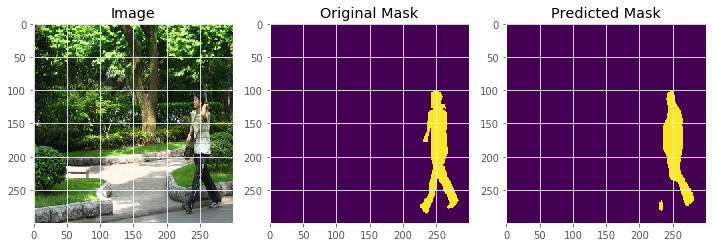

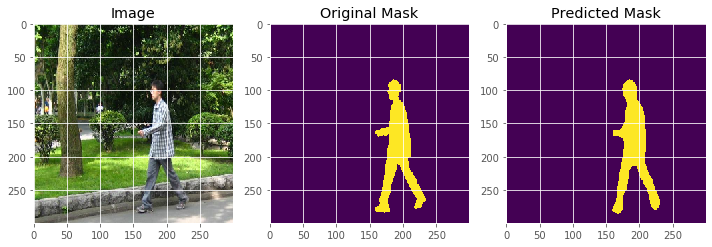

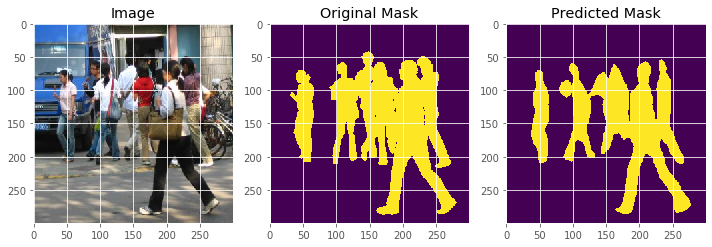

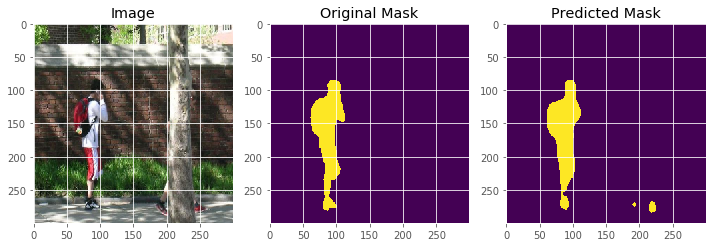

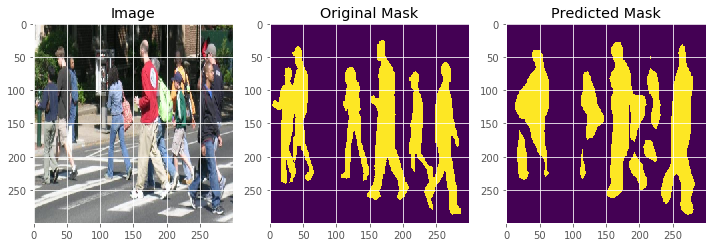

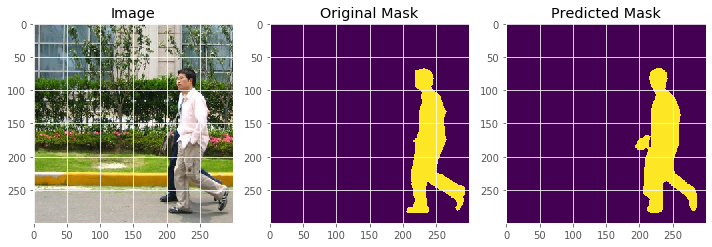

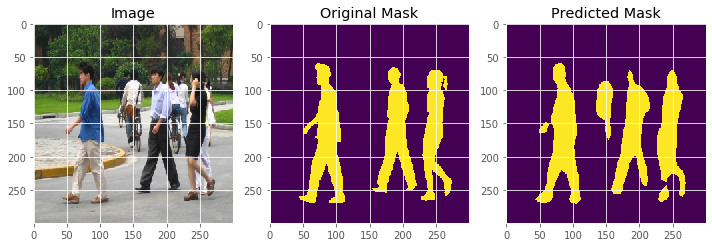

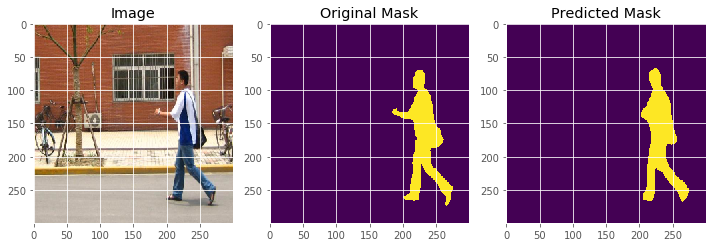

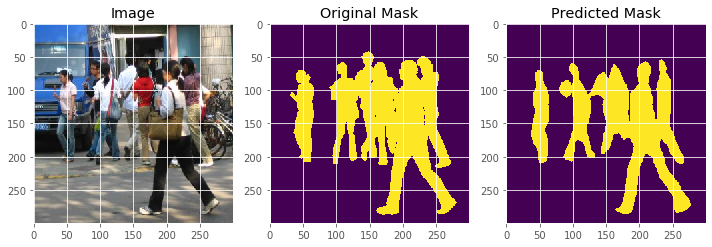

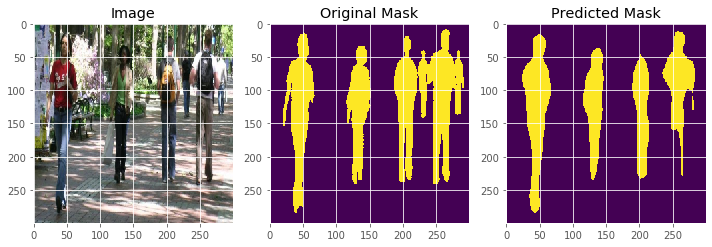

In [16]:
# load the image paths in our testing file and randomly select 10
# image paths
print("[INFO] loading up test image paths...")
imagePaths = open('test.txt').read().strip().split("\n")
imagePaths = np.random.choice(imagePaths, size=10)
# load our model from disk and flash it to the current device
print("[INFO] load up model...")
model = torch.load('best_model.pth').to(device)
# iterate over the randomly selected test image paths
for path in imagePaths:
	# make predictions and visualize the results
	make_predictions(model, path)